# Train a Multiclass Logistic Regression Classifier to Predict _KRAS_, _NRAS_ mutations in Multiple Myeloma

**Gregory Way 2018**

The following notebook contains code to train a multiclass logistic regression classifier to predict _KRAS_ and _NRAS_ mutations in multiple myeloma RNAseq data from the [MMRF CoMMpass Study](https://www.themmrf.org/research-partners/mmrf-data-bank/the-mmrf-commpass-study/).
Previously, we trained a Ras activation classifier ([Way et al. 2018](https://doi.org/10.1016/j.celrep.2018.03.046 "Machine Learning Detects Pan-cancer Ras Pathway Activation in The Cancer Genome Atlas")) and an abberant TP53 classifier ([Knijnenburg et al. 2018](https://doi.org/10.1016/j.celrep.2018.03.076 "Genomic and Molecular Landscape of DNA Damage Repair Deficiency across The Cancer Genome Atlas")) using TCGA PanCanAtlas RNAseq data and an NF1 inactivation classifier in glioblastoma ([Way et al. 2017](https://doi.org/10.1186/s12864-017-3519-7 "A machine learning classifier trained on cancer transcriptomes detects NF1 inactivation signal in glioblastoma")). We have also implemented classifiers on a larger scale and made the models accessible to non-computational biologists (see [Project Cognoma](http://cognoma.org)).

Here, we implemented a one vs. rest (ovr) [multiclass classifier](https://en.wikipedia.org/wiki/Multiclass_classification) to predict _KRAS_ and _NRAS_ mutations separately in multiple myeloma.
The hypothesis was that the two mutations result in different downstream biology that machine learning classifiers can detect. Detecting the two mutations separately can potentially inform different treatment options.

Our collaborators at UCSF (Arun Wiita and Tony Lin) randomly partitioned 10% (mutation-balanced) of the input gene expression data into training (n = 706) and testing (n = 80) sets. We used the training set with the [sklearn.linear_model.LogisticRegression](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) class to train models. We selected optimal regularization (`C`) and penalty (`l1` vs. `l2` loss) terms following 5 fold cross validation. We observed optimal hyperparameters of `C=0.5` and `penalty=l1`. We applied the model to the held out test set to assess performance. We also apply the model to a series of 26 multiple myeloma samples with dual _KRAS_/_NRAS_ mutations.

## Notebook Outputs

The output of this notebook are:

1. Predictions for each class for training, testing, and dual mutation sets.
2. Gene coefficients (importance scores) for each ovr multiclass classifier.
3. Receiver operating characteristic (ROC) and precision-recall (PR) curves for training, testing, and randomly shuffled predictions for each ovr classifier

In [1]:
import os
import random
import numpy as np
import pandas as pd

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

from dask_searchcv import GridSearchCV
from sklearn.pipeline import Pipeline

from sklearn.metrics import make_scorer, f1_score
from sklearn.metrics import average_precision_score, roc_auc_score
from sklearn.metrics import roc_curve, precision_recall_curve

import matplotlib.pyplot as plt
import seaborn as sns

from utils import shuffle_columns

In [2]:
%matplotlib inline

In [3]:
random.seed(1234)

In [4]:
# hyperparameters to loop over
cs = [0.001, 0.2, 0.4, 0.45, 0.5, 0.55, 0.6, 1, 10]
penalties = ['l1', 'l2']

In [5]:
# Read in training RNAseq data (X matrix)
file = os.path.join('data', 'compass_x_train.tsv.gz')
x_df = pd.read_table(file, index_col=0)

print(x_df.shape)
x_df.head(2)

(706, 8000)


,ENSG00000000419,ENSG00000001036,ENSG00000001167,ENSG00000001461,ENSG00000001561,ENSG00000001629,ENSG00000001630,ENSG00000001631,ENSG00000002330,ENSG00000002549,...,ENSG00000273015,ENSG00000273018,ENSG00000273047,ENSG00000273061,ENSG00000273148,ENSG00000273173,ENSG00000273271,ENSG00000273338,ENSG00000273344,ENSG00000273472
MMRF_1021_1_BM,0.262806,0.141701,0.232063,0.898873,0.244057,0.143543,0.191263,0.236492,0.113772,0.065794,...,0.114357,0.027235,0.261604,0.028061,0.091454,0.405908,0.059085,0.015499,0.073543,0.112995
MMRF_1024_2_BM,0.093551,0.086395,0.289861,0.332139,0.179032,0.164444,0.129692,0.244838,0.216607,0.012249,...,0.216129,0.165175,0.100064,0.047545,0.139003,0.227546,0.046127,0.004449,0.132361,0.196722


In [6]:
# Read in training status data (Y matrix)
# Wildtype = 0, KRAS mut = 1, NRAS mut = 2
file = os.path.join('data', 'compass_y_train.tsv')
y_df = pd.read_table(file, index_col=0)

print(y_df.shape)
print(y_df.ras_status.value_counts())
y_df.head(2)

(706, 1)
0    439
1    138
2    129
Name: ras_status, dtype: int64


,ras_status
MMRF_1021_1_BM,1
MMRF_1024_2_BM,0


## 5-Fold Cross Validation

### Initialize Pipeline

In [7]:
# Build the 5-fold cross validation architecture
clf_parameters = {'classify__C': cs,
                  'classify__penalty': penalties}

estimator = Pipeline(
    steps=[
        ('classify',
         LogisticRegression(random_state=123,
                            class_weight='balanced',
                            multi_class='ovr',
                            max_iter=100,
                            solver='saga')
        )
    ]
)

# Custom scorer that optimizes f1 score weighted by class proportion
weighted_f1_scorer = make_scorer(f1_score, average='weighted')

# Cross validation pipeline
cv_pipeline = GridSearchCV(estimator=estimator,
                           param_grid=clf_parameters,
                           n_jobs=-1,
                           cv=5,
                           scoring=weighted_f1_scorer)

### Fit Model

This takes about 10 minutes to train. For many model parameters, sklearn will throw convergence warnings. This means that after 100 iterations, an optimal solution is not found.

In [8]:
%%time
cv_pipeline.fit(X=x_df, y=y_df.ras_status)

/home/greg/anaconda3/envs/multiple-myeloma-classifier/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/greg/anaconda3/envs/multiple-myeloma-classifier/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/greg/anaconda3/envs/multiple-myeloma-classifier/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/greg/anaconda3/envs/multiple-myeloma-classifier/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being

/home/greg/anaconda3/envs/multiple-myeloma-classifier/lib/python3.5/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/greg/anaconda3/envs/multiple-myeloma-classifier/lib/python3.5/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/greg/anaconda3/envs/multiple-myeloma-classifier/lib/python3.5/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/greg/anaconda3/envs/multiple-myeloma-classifier/lib/python3.5/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarni

/home/greg/anaconda3/envs/multiple-myeloma-classifier/lib/python3.5/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/greg/anaconda3/envs/multiple-myeloma-classifier/lib/python3.5/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/greg/anaconda3/envs/multiple-myeloma-classifier/lib/python3.5/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/greg/anaconda3/envs/multiple-myeloma-classifier/lib/python3.5/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarni

CPU times: user 25min 7s, sys: 1.69 s, total: 25min 8s
Wall time: 6min 45s


GridSearchCV(cache_cv=True, cv=5, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('classify', LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=123,
          solver='saga', tol=0.0001, verbose=0, warm_start=False))]),
       iid=True, n_jobs=-1,
       param_grid={'classify__penalty': ['l1', 'l2'], 'classify__C': [0.001, 0.2, 0.4, 0.45, 0.5, 0.55, 0.6, 1, 10]},
       refit=True, return_train_score='warn', scheduler=None,
       scoring=make_scorer(f1_score, average=weighted))

In [9]:
# Compile cross validation results
cv_results = (
    pd.concat([
        pd.DataFrame(cv_pipeline.cv_results_).drop('params', axis=1),
        pd.DataFrame.from_records(cv_pipeline.cv_results_['params'])
    ], axis=1)
)

cv_results.sort_values(by='rank_test_score').head(5)

/home/greg/anaconda3/envs/multiple-myeloma-classifier/lib/python3.5/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in sklearn 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/home/greg/anaconda3/envs/multiple-myeloma-classifier/lib/python3.5/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in sklearn 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/home/greg/anaconda3/envs/multiple-myeloma-classifier/lib/python3.5/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in sklearn 0.21. If you need training sc

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_classify__C,param_classify__penalty,rank_test_score,split0_test_score,split0_train_score,split1_test_score,...,split3_test_score,split3_train_score,split4_test_score,split4_train_score,std_fit_time,std_score_time,std_test_score,std_train_score,classify__C,classify__penalty
6,23.241233,0.008274,0.683142,0.856544,0.45,l1,1,0.660575,0.862091,0.696500,...,0.670977,0.858624,0.691736,0.845647,0.986659,0.007547,0.014689,0.007886,0.45,l1
10,20.666868,0.003933,0.682141,0.877623,0.55,l1,2,0.671317,0.881974,0.690162,...,0.670475,0.882318,0.688554,0.869235,0.172617,0.000057,0.009220,0.007235,0.55,l1
8,21.143557,0.003945,0.681021,0.865808,0.5,l1,3,0.658237,0.871795,0.690162,...,0.670475,0.865431,0.694746,0.856169,0.425085,0.000051,0.014264,0.007221,0.50,l1
4,20.036211,0.003959,0.680797,0.841246,0.4,l1,4,0.660575,0.850048,0.690326,...,0.665456,0.836689,0.691736,0.831620,0.106107,0.000081,0.014754,0.009543,0.40,l1
12,21.276818,0.003957,0.680220,0.888174,0.6,l1,5,0.669203,0.890546,0.681623,...,0.664984,0.892592,0.695558,0.882910,0.259670,0.000052,0.011685,0.003982,0.60,l1


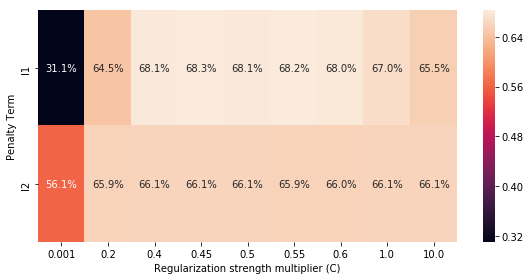

In [10]:
# Cross-validated performance heatmap
cv_score_mat = pd.pivot_table(cv_results,
                              values='mean_test_score',
                              index='classify__penalty',
                              columns='classify__C')

plt.subplots(figsize=(8,4))
ax = sns.heatmap(cv_score_mat, annot=True, fmt='.1%')
ax.set_xlabel('Regularization strength multiplier (C)')
ax.set_ylabel('Penalty Term')
plt.tight_layout()

## Output Results from Optimal Model

### Extract and Save Classifier Coefficients

In [ ]:
path = os.path.join('results', 'classifier')
if not os.path.exists(path):
    os.makedirs(path)

In [11]:
coef_df = pd.DataFrame(
    cv_pipeline
    .best_estimator_
    .named_steps['classify']
    .coef_).T

coef_df.columns = ['wildtype', 'KRAS', 'NRAS']
coef_df.index = x_df.columns
coef_df.index.name = 'GENE_ID'
coef_df = coef_df.sort_values(by='KRAS', ascending=False)

file = os.path.join('results', 'classifier', 'classifier_coefficients.tsv')
coef_df.to_csv(file, sep='\t')

coef_df.head()

,wildtype,KRAS,NRAS
GENE_ID,,,
ENSG00000244405,-1.250743,1.009203,0.387605
ENSG00000153064,-0.530025,0.880618,0.000000
ENSG00000131187,-0.798638,0.610847,0.293826
ENSG00000184445,-0.188369,0.497889,0.000000
ENSG00000143878,-0.090743,0.477435,0.000000


In [12]:
# How many classifier genes are nonzero?
num_nonzero = (coef_df.sum(axis='columns').abs() > 0).sum()
print('{} genes are nonzero ({} %)'.format(num_nonzero,
                                           (num_nonzero / coef_df.shape[0]) * 100))

834 genes are nonzero (10.424999999999999 %)


In [13]:
# Save the intercept of the multiclass classifier
intercept_df = pd.DataFrame(cv_pipeline.best_estimator_.named_steps['classify'].intercept_).T
intercept_df.columns = ['wildtype', 'KRAS', 'NRAS']
intercept_df.index = ['intercept']

file = os.path.join('results', 'classifier', 'classifier_intercept.tsv')
intercept_df.to_csv(file, sep='\t')

intercept_df

,wildtype,KRAS,NRAS
intercept,0.019241,-0.135418,-0.013919


### Obtain probability estimates for all training samples

In [14]:
scores_df = cv_pipeline.best_estimator_.predict_proba(x_df)

scores_df = pd.DataFrame(scores_df,
                         index=x_df.index,
                         columns=['wildtype', 'KRAS', 'NRAS'])

file = os.path.join('results', 'sample_scores_training_set.tsv')
scores_df.to_csv(file, sep='\t')

print(scores_df.shape)
scores_df.head()

(706, 3)


,wildtype,KRAS,NRAS
MMRF_1021_1_BM,0.475865,0.484389,0.039746
MMRF_1024_2_BM,0.580930,0.143440,0.275630
MMRF_1029_1_BM,0.642070,0.317206,0.040724
MMRF_1030_1_BM,0.229893,0.634433,0.135674
MMRF_1032_1_BM,0.186391,0.652252,0.161357


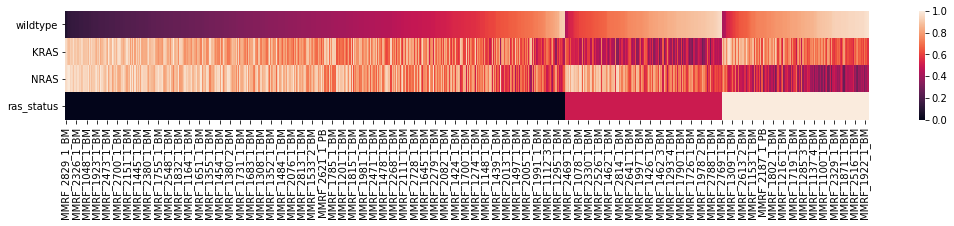

In [15]:
# Visualize probability estimates against ground truth status
# Compress Y to between 0 and 1 (in other words, 0 = wildtype, 0.5 = KRAS, 1 = NRAS)
# Do this for visualization purposes only
y_compress = pd.DataFrame(MinMaxScaler().fit_transform(y_df),
                          index=y_df.index,
                          columns=y_df.columns)

score_heatmap = (
    (1 - scores_df)
    .join(y_compress)
    .sort_values(by=['ras_status', 'wildtype', 'KRAS', 'NRAS'])
    .T
)

plt.subplots(figsize=(18,2))
sns.heatmap(score_heatmap);

## Apply Classifier to Testing and Shuffled Sets

A shuffled matrix will determine how the model would have performed withough any signal. This tests if class imbalance induces biased metrics.

### Load and process testing set

Scores for this set are output as well.

In [16]:
# Read in testing RNAseq data (X matrix)
file = os.path.join('data', 'compass_x_test.tsv.gz')
x_test_df = pd.read_table(file, index_col=0)

print(x_test_df.shape)
x_test_df.head(2)

(80, 8000)


,ENSG00000000419,ENSG00000001036,ENSG00000001167,ENSG00000001461,ENSG00000001561,ENSG00000001629,ENSG00000001630,ENSG00000001631,ENSG00000002330,ENSG00000002549,...,ENSG00000273015,ENSG00000273018,ENSG00000273047,ENSG00000273061,ENSG00000273148,ENSG00000273173,ENSG00000273271,ENSG00000273338,ENSG00000273344,ENSG00000273472
MMRF_1031_1_BM,0.326370,0.596335,0.344306,0.567132,0.30146,0.521037,0.774628,0.584674,0.157592,0.177852,...,0.015132,0.000538,0.103802,0.401913,0.000000,0.250046,0.000000,0.019345,0.000000,0.046624
MMRF_1061_3_BM,0.323875,0.399151,0.115825,0.028722,0.05642,0.101386,0.189894,0.170306,0.151529,0.454534,...,0.000000,0.064040,0.240474,0.212262,0.459964,0.295921,0.339385,0.163530,0.182979,0.497492


In [17]:
# Read in testing status data (Y matrix)
# Wildtype = 0, KRAS mut = 1, NRAS mut = 2
file = os.path.join('data', 'compass_y_test.tsv')
y_test_df = pd.read_table(file, index_col=0)

print(y_test_df.shape)
print(y_test_df.ras_status.value_counts())
y_test_df.head(2)

(80, 1)
0    49
1    16
2    15
Name: ras_status, dtype: int64


,ras_status
MMRF_1031_1_BM,0
MMRF_1061_3_BM,2


In [18]:
# Apply classifier to testing data and get scores
test_scores_df = cv_pipeline.best_estimator_.predict_proba(x_test_df)
test_scores_df = pd.DataFrame(test_scores_df,
                              index=x_test_df.index,
                              columns=['wildtype', 'KRAS', 'NRAS'])

file = os.path.join('results', 'sample_scores_testing_set.tsv')
test_scores_df.to_csv(file, sep='\t')

print(test_scores_df.shape)
test_scores_df.head(2)

(80, 3)


,wildtype,KRAS,NRAS
MMRF_1031_1_BM,0.049031,0.742350,0.208619
MMRF_1061_3_BM,0.008679,0.503285,0.488036


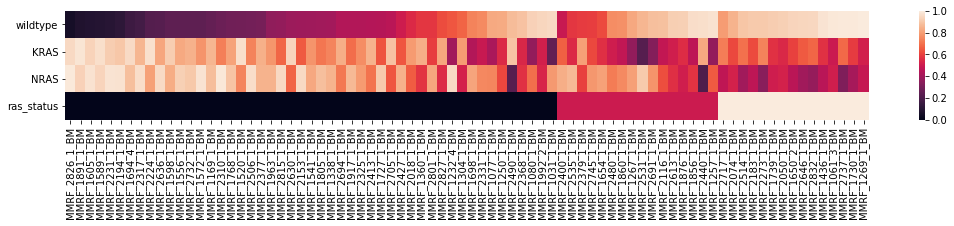

In [19]:
# Visualize probability estimates against ground truth status for the testing set
# Compress Y to between 0 and 1 (in other words, 0 = wildtype, 0.5 = KRAS, 1 = NRAS)
# Do this for visualization purposes only
y_test_compress = pd.DataFrame(MinMaxScaler().fit_transform(y_test_df),
                               index=y_test_df.index,
                               columns=y_test_df.columns)

score_heatmap = (
    (1 - test_scores_df)
    .join(y_test_compress)
    .sort_values(by=['ras_status', 'wildtype', 'KRAS', 'NRAS'])
    .T
)

plt.subplots(figsize=(18,2))
sns.heatmap(score_heatmap);

### Get a Shuffled Training X Matrix

In [20]:
# Shuffle training X matrix to observe potential metric inflation
# as a result of class imbalance
x_shuffled_df = x_df.apply(shuffle_columns, axis=1)

In [21]:
shuffle_scores_df = cv_pipeline.best_estimator_.predict_proba(x_shuffled_df)
shuffle_scores_df = pd.DataFrame(shuffle_scores_df,
                                 index=x_df.index,
                                 columns=['wildtype', 'KRAS', 'NRAS'])

print(shuffle_scores_df.shape)
shuffle_scores_df.head()

(706, 3)


,wildtype,KRAS,NRAS
MMRF_1021_1_BM,0.316509,0.459236,0.224255
MMRF_1024_2_BM,0.309947,0.490306,0.199747
MMRF_1029_1_BM,0.355794,0.510607,0.133599
MMRF_1030_1_BM,0.184495,0.350484,0.465022
MMRF_1032_1_BM,0.083756,0.477628,0.438617


## Collect Classification Metrics for Training, Testing, and Shuffled Data

1. False Positive Rate
2. True Positive Rate
3. Precision
4. Recall
5. Area under the ROC (AUROC) Curve
6. Area under the PR (AUPR) Curve

Also output ROC and PR Curves to the `figures` folder.

In [ ]:
path = os.path.join('figures')
if not os.path.exists(path):
    os.makedirs(path)

In [22]:
# Convert the y vector into one hot encoded matrices
# Note that the shuffled matrix will use the same training onehot vector
onehot = OneHotEncoder(sparse=False).fit(y_df)

train_onehot_df = onehot.transform(y_df)
test_onehot_df = onehot.transform(y_test_df)

In [23]:
n_classes = 3

fpr = {}
tpr = {}
precision = {}
recall = {}
auroc = {}
aupr = {}

fpr_test = {}
tpr_test = {}
precision_test = {}
recall_test = {}
auroc_test = {}
aupr_test = {}

fpr_shuff = {}
tpr_shuff = {}
precision_shuff = {}
recall_shuff = {}
auroc_shuff = {}
aupr_shuff = {}

for i in range(n_classes):
    # Obtain Training Metrics
    train_onehot_class = train_onehot_df[:, i]
    train_score_class = scores_df.iloc[:, i]
    
    fpr[i], tpr[i], _ = roc_curve(train_onehot_class, train_score_class)
    precision[i], recall[i], _ = precision_recall_curve(train_onehot_class, train_score_class)
    auroc[i] = roc_auc_score(train_onehot_class, train_score_class)
    aupr[i] = average_precision_score(train_onehot_class, train_score_class)
    
    # Obtain Testing Metrics
    test_onehot_class = test_onehot_df[:, i]
    test_score_class = test_scores_df.iloc[:, i]
    
    fpr_test[i], tpr_test[i], _ = roc_curve(test_onehot_class, test_score_class)
    precision_test[i], recall_test[i], _ = precision_recall_curve(test_onehot_class, test_score_class)
    auroc_test[i] = roc_auc_score(test_onehot_class, test_score_class)
    aupr_test[i] = average_precision_score(test_onehot_class, test_score_class)
    
    # Obtain Shuffled Metrics
    shuff_score_class = shuffle_scores_df.iloc[:, i]
    
    fpr_shuff[i], tpr_shuff[i], _ = roc_curve(train_onehot_class, shuff_score_class)
    precision_shuff[i], recall_shuff[i], _ = precision_recall_curve(train_onehot_class, shuff_score_class)
    auroc_shuff[i] = roc_auc_score(train_onehot_class, shuff_score_class)
    aupr_shuff[i] = average_precision_score(train_onehot_class, shuff_score_class)

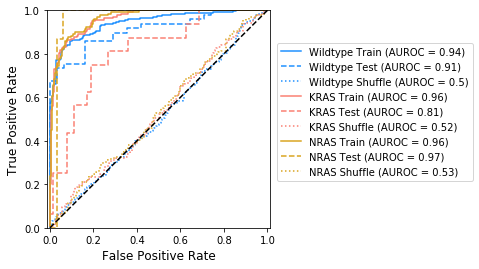

In [24]:
plt.subplots(figsize=(4, 4))

labels = ['Wildtype', 'KRAS', 'NRAS']
colors = ['dodgerblue', 'salmon', 'goldenrod']
for i in range(n_classes):
    # Training Data
    plt.plot(fpr[i], tpr[i],
             label='{} Train (AUROC = {})'.format(labels[i], round(auroc[i], 2)),
             linestyle='solid',
             color=colors[i])

    # Testing Data
    plt.plot(fpr_test[i], tpr_test[i],
             label='{} Test (AUROC = {})'.format(labels[i], round(auroc_test[i], 2)),
             linestyle='dashed',
             color=colors[i])
    
    # Shuffled Data
    plt.plot(fpr_shuff[i], tpr_shuff[i],
             label='{} Shuffle (AUROC = {})'.format(labels[i], round(auroc_shuff[i], 2)),
             linestyle='dotted',
             color=colors[i])

plt.axis('equal')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])

plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)

plt.tick_params(labelsize=10)

lgd = plt.legend(bbox_to_anchor=(1.03, 0.85),
                 loc=2,
                 borderaxespad=0.,
                 fontsize=10)

file = os.path.join('figures', 'roc_curve.pdf')
plt.savefig(file, bbox_extra_artists=(lgd,), bbox_inches='tight')

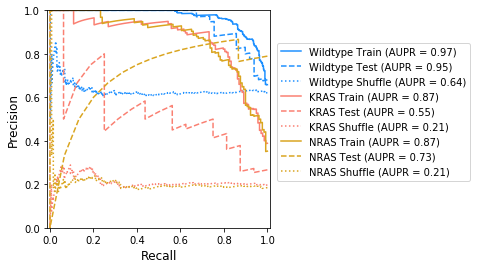

In [25]:
plt.subplots(figsize=(4, 4))

for i in range(n_classes):
    # Training Data
    plt.plot(recall[i], precision[i],
             label='{} Train (AUPR = {})'.format(labels[i], round(aupr[i], 2)),
             linestyle='solid',
             color=colors[i])

    # Testing Data
    plt.plot(recall_test[i], precision_test[i],
             label='{} Test (AUPR = {})'.format(labels[i], round(aupr_test[i], 2)),
             linestyle='dashed',
             color=colors[i])

    # Shuffled Data
    plt.plot(recall_shuff[i], precision_shuff[i],
             label='{} Shuffle (AUPR = {})'.format(labels[i], round(aupr_shuff[i], 2)),
             linestyle='dotted',
             color=colors[i])

plt.axis('equal')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])

plt.xlabel('Recall', fontsize=12)
plt.ylabel('Precision', fontsize=12)

plt.tick_params(labelsize=10)

lgd = plt.legend(bbox_to_anchor=(1.03, 0.85),
                 loc=2,
                 borderaxespad=0.,
                 fontsize=10)

file = os.path.join('figures', 'pr_curve.pdf')
plt.savefig(file, bbox_extra_artists=(lgd,), bbox_inches='tight')

## Load Dual Ras Samples and Apply Classifier

Output classifier scores per Dual Ras mutated sample

In [26]:
# Read in dual RNAseq data (X matrix)
file = os.path.join('data', 'compass_x_dual.tsv.gz')
x_dual_df = pd.read_table(file, index_col=0)

print(x_dual_df.shape)
x_dual_df.head(2)

(26, 8000)


,ENSG00000000419,ENSG00000001036,ENSG00000001167,ENSG00000001461,ENSG00000001561,ENSG00000001629,ENSG00000001630,ENSG00000001631,ENSG00000002330,ENSG00000002549,...,ENSG00000273015,ENSG00000273018,ENSG00000273047,ENSG00000273061,ENSG00000273148,ENSG00000273173,ENSG00000273271,ENSG00000273338,ENSG00000273344,ENSG00000273472
MMRF_1089_1_BM,0.343731,0.414648,0.295207,0.348153,0.106885,0.556205,0.347565,0.397318,0.733030,0.191631,...,0.113103,0.232349,0.086918,0.187413,0.509077,0.213994,0.362557,0.163217,0.337261,0.108434
MMRF_1129_1_BM,0.239659,0.487862,0.871547,0.466620,0.133573,0.402914,0.528391,0.775043,0.227491,0.265912,...,0.523482,0.002066,0.312387,0.408765,0.488954,0.395000,0.184231,0.126850,0.529621,0.313337


In [27]:
# Apply classifier to dual data and save scores
dual_scores_df = cv_pipeline.best_estimator_.predict_proba(x_dual_df)
dual_scores_df = pd.DataFrame(dual_scores_df,
                              index=x_dual_df.index,
                              columns=['wildtype', 'KRAS', 'NRAS'])

file = os.path.join('results', 'sample_scores_dual_set.tsv')
dual_scores_df = dual_scores_df.sort_values(by='wildtype')
dual_scores_df.to_csv(file, sep='\t')

print(dual_scores_df.shape)
dual_scores_df.head()

(26, 3)


,wildtype,KRAS,NRAS
MMRF_2772_1_BM,0.006945,0.504755,0.488301
MMRF_1614_1_BM,0.017353,0.413779,0.568868
MMRF_2639_1_BM,0.022582,0.504931,0.472487
MMRF_2677_1_BM,0.022862,0.596119,0.381019
MMRF_2106_1_BM,0.036993,0.605097,0.357909


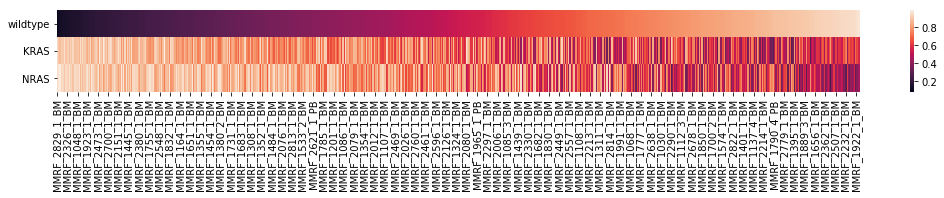

In [28]:
# Visualize dual Ras sample score heatmap
dual_score_heatmap = (
    (1 -scores_df)
    .sort_values(by=['wildtype', 'KRAS', 'NRAS'])
    .T
)

plt.subplots(figsize=(18,1.5))
g = sns.heatmap(dual_score_heatmap);